Exploring Transfer Learning with Pre-trained Models

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
print("Downloading Cats vs Dogs dataset...")

_URL = 'https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file(
    'cats_and_dogs.zip',
    origin=_URL,
    extract=True
)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print("Dataset loaded successfully!")


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset loaded successfully!


In [ ]:
# Re-evaluate paths based on kernel state for path_to_zip
# path_to_zip was found to be '/root/.keras/datasets/cats_and_dogs_extracted' in the kernel state.
# The actual dataset content is typically in a subdirectory named 'cats_and_dogs_filtered' inside the extracted folder.
corrected_PATH = os.path.join(path_to_zip, 'cats_and_dogs_filtered')
corrected_train_dir = os.path.join(corrected_PATH, 'train')
corrected_validation_dir = os.path.join(corrected_PATH, 'validation')

train_cats = len(os.listdir(os.path.join(corrected_train_dir, 'cats')))
train_dogs = len(os.listdir(os.path.join(corrected_train_dir, 'dogs')))
val_cats = len(os.listdir(os.path.join(corrected_validation_dir, 'cats')))
val_dogs = len(os.listdir(os.path.join(corrected_validation_dir, 'dogs')))

print(f"Training Cats: {train_cats}")
print(f"Training Dogs: {train_dogs}")
print(f"Validation Cats: {val_cats}")
print(f"Validation Dogs: {val_dogs}")

Training Cats: 1000
Training Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


In [ ]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    corrected_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    corrected_validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class labels:", train_generator.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class labels: {'cats': 0, 'dogs': 1}


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Phase 1 Feature Extraction & Training Top Layers

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_vgg16_model.h5", save_best_only=True)
]

print("Phase 1: Training top layers only")

history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Phase 1: Training top layers only


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6456 - loss: 2.9850

63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.6468 - loss: 2.9661 - val_accuracy: 0.9330 - val_loss: 0.2349
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8725 - loss: 0.6785

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.8727 - loss: 0.6770 - val_accuracy: 0.9570 - val_loss: 0.1730
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8963 - loss: 0.4791

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 0.8963 - loss: 0.4794 - val_accuracy: 0.9560 - val_loss: 0.1611
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9208 - loss: 0.3439

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.9208 - loss: 0.3437 - val_accuracy: 0.9600 - val_loss: 0.1379
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.9236 - loss: 0.3386 - val_accuracy: 0.9500 - val_loss: 0.1754
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9384 - loss: 0.3081

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.9383 - loss: 0.3081 - val_accuracy: 0.9660 - val_loss: 0.1280
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.9291 - loss: 0.3268 - val_accuracy: 0.9560 - val_loss: 0.1465
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9475 - loss: 0.2318

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.9474 - loss: 0.2320 - val_accuracy: 0.9700 - val_loss: 0.1258
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 304ms/step - accuracy: 0.9442 - loss: 0.2423 - val_accuracy: 0.9570 - val_loss: 0.1428
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.9453 - loss: 0.2070 - val_accuracy: 0.9570 - val_loss: 0.1387


In [ ]:
train_acc_phase1 = history_phase1.history['accuracy'][-1]
val_acc_phase1 = history_phase1.history['val_accuracy'][-1]

print(f"Phase 1 - Training Accuracy: {train_acc_phase1*100:.2f}%")
print(f"Phase 1 - Validation Accuracy: {val_acc_phase1*100:.2f}%")


Phase 1 - Training Accuracy: 94.25%
Phase 1 - Validation Accuracy: 95.70%


Phase 2- Fine Tuning


In [ ]:
print("Unfreezing top VGG16 layers for fine-tuning...")

base_model.trainable = True

for layer in base_model.layers[:-16]:
    layer.trainable = False


Unfreezing top VGG16 layers for fine-tuning...


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Phase 2: Fine-tuning")

history_phase2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Phase 2: Fine-tuning
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9370 - loss: 0.2253

63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 586ms/step - accuracy: 0.9370 - loss: 0.2248 - val_accuracy: 0.9670 - val_loss: 0.0885
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9495 - loss: 0.1423

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9495 - loss: 0.1422 - val_accuracy: 0.9680 - val_loss: 0.0860
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9670 - loss: 0.0915

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.9671 - loss: 0.0913 - val_accuracy: 0.9720 - val_loss: 0.0781
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - accuracy: 0.9609 - loss: 0.0953 - val_accuracy: 0.9650 - val_loss: 0.0861
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9663 - loss: 0.0803

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - accuracy: 0.9664 - loss: 0.0800 - val_accuracy: 0.9740 - val_loss: 0.0667
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step - accuracy: 0.9787 - loss: 0.0607 - val_accuracy: 0.9710 - val_loss: 0.0766
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9839 - loss: 0.0370

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.9839 - loss: 0.0372 - val_accuracy: 0.9780 - val_loss: 0.0597
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - accuracy: 0.9837 - loss: 0.0420 - val_accuracy: 0.9740 - val_loss: 0.0728
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.9904 - loss: 0.0300 - val_accuracy: 0.9720 - val_loss: 0.0849
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.9872 - loss: 0.0286 - val_accuracy: 0.9800 - val_loss: 0.0626


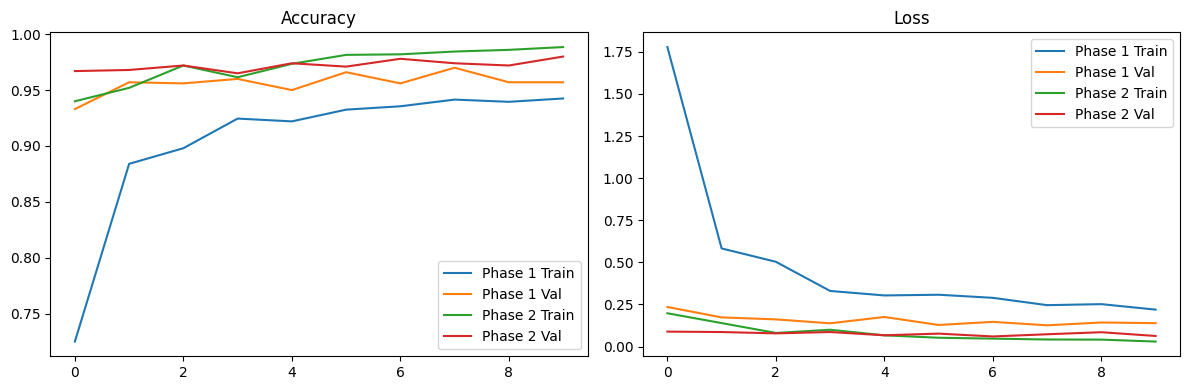

In [ ]:
def plot_history(histories, titles):
    plt.figure(figsize=(12,4))

    for i, hist in enumerate(histories):
        plt.subplot(1,2,1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title("Accuracy")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title("Loss")
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(
    [history_phase1, history_phase2],
    ["Phase 1", "Phase 2"]
)


In [ ]:
loss, acc = model.evaluate(validation_generator, verbose=0)
print(f"Final Validation Accuracy: {acc*100:.2f}%")


Final Validation Accuracy: 97.80%


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step
              precision    recall  f1-score   support

         Cat       0.98      0.98      0.98       500
         Dog       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



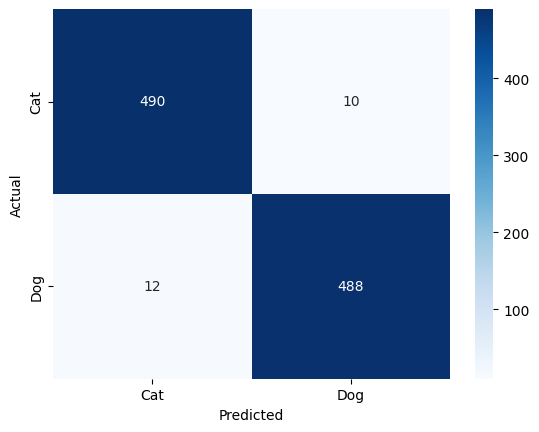

In [ ]:
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)

print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Cat', 'Dog'],
    yticklabels=['Cat', 'Dog']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


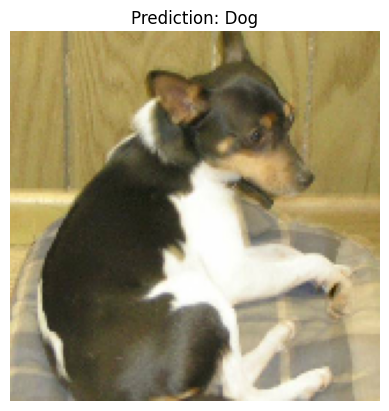

In [ ]:
img_path = random.choice(validation_generator.filepaths)

img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)[0][0]
label = "Dog" if prediction > 0.5 else "Cat"

plt.imshow(img)
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()


In [ ]:
model.save("vgg16_cats_dogs_transfer_learning.h5")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    corrected_validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1000 images belonging to 2 classes.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving raoul-droog-yMSecCHsIBc-unsplash.jpg.crdownload to raoul-droog-yMSecCHsIBc-unsplash.jpg (1).crdownload


In [ ]:
img_path = list(uploaded.keys())[0]
print("Uploaded image:", img_path)


Uploaded image: raoul-droog-yMSecCHsIBc-unsplash.jpg (1).crdownload


In [ ]:
from tensorflow.keras.preprocessing import image

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)[0][0]

label = "Dog" if prediction > 0.5 else "Cat"
confidence = prediction if prediction > 0.5 else 1 - prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


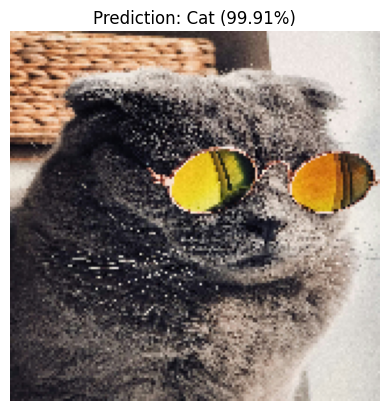

In [ ]:
plt.imshow(img)
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
plt.axis('off')
plt.show()
